# Transfer learning
- [Resource](https://lightning.ai/courses/deep-learning-fundamentals/unit-7-overview-getting-started-with-computer-vision/unit-7.6-leveraging-pretrained-models-with-transfer-learning/)

In [1]:
from pathlib import Path
import shutil as sh
from typing import Optional
from PIL import Image
import requests

In [2]:
!pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 50.7 MB/s eta 0:00:00


In [3]:
!pip install -q grad-cam torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [4]:
import os
from typing import Optional

import torch
import numpy as np
import torch.nn as nn
import albumentations as A
import lightning as L
import torchvision as tv
import torchvision.datasets as tv_ds
import torchvision.models as tv_models

from torchvision.transforms import v2
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split

# Note - you must have torchvision installed for this example
# from torchvision.datasets import MNIST

from typing import Optional

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryAUROC,
    BinaryAveragePrecision,
    BinaryF1Score,
    BinaryStatScores,
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Download data

In [5]:
!curl -L -o ./archive.zip https://www.kaggle.com/api/v1/datasets/download/fanconic/skin-cancer-malignant-vs-benign

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  324M  100  324M    0     0  18.8M      0  0:00:17  0:00:17 --:--:-- 22.6M


In [6]:
!rm -rf dataset
!rm -rf final_dataset
!unzip -q archive.zip -d dataset

In [7]:
DATASET_PATH = Path("/content/final_dataset")

TRAIN_DS_PATH = DATASET_PATH / "train"
TEST_DS_PATH = DATASET_PATH / "test"
VALID_DS_PATH = DATASET_PATH / "valid"

TRAIN_DS_PATH.mkdir(parents=True, exist_ok=True)
TEST_DS_PATH.mkdir(parents=True, exist_ok=True)
VALID_DS_PATH.mkdir(parents=True, exist_ok=True)

In [8]:
def copy_files(
        src_dir: Path,
        dest_dir: Path,
        file_pattern: str,
        num_files: Optional[int] = None,
        verbose: bool = False,
    ):
    dest_dir.mkdir(parents=True, exist_ok=True)
    files = src_dir.glob(file_pattern)
    counts = 0
    for file_ in sorted(files):
        if num_files and counts >= num_files:
            break
        if verbose:
            print(f"Copying {file_} to {dest_dir}...")
        counts += 1
        sh.move(file_, dest_dir)

In [9]:

test_dir = Path("/content/dataset/test")
copy_files(test_dir / "benign", TEST_DS_PATH / "benign", file_pattern="*.jpg")
copy_files(test_dir / "malignant", TEST_DS_PATH / "malignant", file_pattern="*.jpg")
print(f"test malignant - {len(list((TEST_DS_PATH / 'malignant').glob('*.jpg')))}")
print(f"test benign - {len(list((TEST_DS_PATH / 'benign').glob('*.jpg')))}")

train_dir = Path("/content/dataset/train")
copy_files(train_dir / "benign", VALID_DS_PATH / "benign", file_pattern="*.jpg", num_files=300)
copy_files(train_dir / "malignant", VALID_DS_PATH / "malignant", file_pattern="*.jpg", num_files=300)
print(f"valid malignant - {len(list((VALID_DS_PATH / 'malignant').glob('*.jpg')))}")
print(f"valid benign - {len(list((VALID_DS_PATH / 'benign').glob('*.jpg')))}")

copy_files(train_dir / "benign", TRAIN_DS_PATH / "benign", file_pattern="*.jpg")
copy_files(train_dir / "malignant", TRAIN_DS_PATH / "malignant", file_pattern="*.jpg")
print(f"train malignant - {len(list((TRAIN_DS_PATH / 'malignant').glob('*.jpg')))}")
print(f"train benign - {len(list((TRAIN_DS_PATH / 'benign').glob('*.jpg')))}")

!rm -rf ./dataset


test malignant - 300
test benign - 360
valid malignant - 300
valid benign - 300
train malignant - 897
train benign - 1140


##  Lightning data module

In [10]:
# @title

# ruff: noqa: F401

# https://lightning.ai/docs/pytorch/stable/data/datamodule.html

class Transform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        # print(image)
        image = np.array(image)
        return self.transform(image=image)["image"]

class ImgDataModule(L.LightningDataModule):
    def __init__(
        self,
        train_data_dir: str,
        valid_data_dir: Optional[str],
        test_data_dir: Optional[str],
        val_transforms_: v2.Compose | A.Compose,
        train_transforms_: Optional[v2.Compose | A.Compose] = None,
        batch_size: int = 32,
    ):
        super().__init__()
        self.train_data_dir = train_data_dir
        self.valid_data_dir = valid_data_dir
        self.test_data_dir = test_data_dir
        self.batch_size = batch_size
        self.train_transforms_ = train_transforms_
        self.val_transforms_ = val_transforms_
        self.num_cpu = max([os.cpu_count(), 2])

    def train_dataloader(self):
        self.train_dataset = tv_ds.ImageFolder(
            self.train_data_dir,
            transform=Transform(self.train_transforms_),
        )
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=min([self.num_cpu, 4]),
            persistent_workers=True,
        )

    def val_dataloader(self):
        if self.valid_data_dir:
            self.valid_dataset = tv_ds.ImageFolder(
                self.valid_data_dir,
                transform=Transform(self.val_transforms_),
            )
            return DataLoader(
                self.valid_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=min([self.num_cpu, 4]),
                persistent_workers=True,
            )

    def test_dataloader(self):
        if self.test_data_dir:
            self.test_dataset = tv_ds.ImageFolder(
                self.test_data_dir,
                transform=Transform(self.val_transforms_),
            )
            return DataLoader(
                self.test_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=min([self.num_cpu, 4]),
            )


In [11]:
MODEL_BACKBONE_WTS = tv_models.MobileNet_V2_Weights.IMAGENET1K_V2

In [12]:
# @title Selecting backbone
MODEL_BACKBONE_WTS = tv_models.MobileNet_V2_Weights.IMAGENET1K_V2

# check transformations corresponding to backbone
prep_transforms = MODEL_BACKBONE_WTS.transforms()
prep_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [13]:
# @title Build Lightning data module

compulsory_transforms = A.Compose(
        [
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    )

datamodule = ImgDataModule(
    train_data_dir=TRAIN_DS_PATH,
    valid_data_dir=VALID_DS_PATH,
    test_data_dir=TEST_DS_PATH,
    batch_size=128,
    # Add backbone transformations as train and valid transforms
    train_transforms_=A.Compose(
        [
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    ),
    val_transforms_=compulsory_transforms,
)


In [14]:
train_dl = datamodule.train_dataloader()
test_dl = datamodule.test_dataloader()
val_dl = datamodule.val_dataloader()

In [15]:
train_ds = datamodule.train_dataset
valid_ds = datamodule.valid_dataset
test_ds = datamodule.test_dataset

In [16]:
for x in train_ds:
    break
x[0].shape, x[0].dtype

(torch.Size([3, 224, 224]), torch.float32)

In [17]:
for y in train_dl:
    break
y[0].shape, y[0].dtype

(torch.Size([128, 3, 224, 224]), torch.float32)

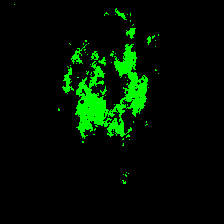

In [18]:
Image.fromarray(torch.permute(x[0].detach().clone(), (1, 2, 0)).type(torch.uint8).numpy())

In [19]:
from collections import Counter

In [20]:
lbls = []
for tensor, lbl in train_ds:
    # print(tensor.shape, lbl)
    lbls.append(lbl)
Counter(lbls)

Counter({0: 1140, 1: 897})

## Model building

In [21]:
# @title Model definition

class classifictionModel(L.LightningModule):
    def __init__(
        self,
        lr: float,
        monitor_metric: str,
        monitor_mode: str,  # min | max
        pos_weight: Optional[float] = None,  # num positive / num negatives
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.save_hyperparameters(ignore=["model"])
        # ------------- build feature extractor and model -------------
        num_target_classes = 2
        model = tv_models.mobilenet_v2(weights=MODEL_BACKBONE_WTS)
        num_filters = model.classifier[1].in_features # backbone.classifier.in_features
        model.classifier[1] = nn.Linear(num_filters, num_target_classes)
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.learning_rate = lr
        self.monitor_metric = monitor_metric
        self.monitor_mode = monitor_mode  # min | max
        # -------- METRICS --------
        self.train_f1 = BinaryF1Score()
        self.train_auroc = BinaryAUROC()
        self.train_accuracy = BinaryAccuracy()
        self.train_ap = BinaryAveragePrecision()
        self.train_stats_score = BinaryStatScores()

        self.valid_f1 = BinaryF1Score()
        self.valid_auroc = BinaryAUROC()
        self.valid_accuracy = BinaryAccuracy()
        self.valid_ap = BinaryAveragePrecision()
        self.valid_stats_score = BinaryStatScores()

        self.test_f1 = BinaryF1Score()
        self.test_auroc = BinaryAUROC()
        self.test_accuracy = BinaryAccuracy()
        self.test_ap = BinaryAveragePrecision()
        self.test_stats_score = BinaryStatScores()

        self.train_outs = []
        self.valid_outs = []
        self.test_outs = []

    def forward(self, batch: torch.FloatTensor, probab=False):
        out = self.model(batch)
        if probab:
            out = out.softmax(dim=1)
        return out


    def predict_step(self, batch):
        return self(batch, probab=True)

    def _shared_step(self, batch):
        X, actual_labels = batch
        # if we are using BCE with Logit Loss, we don't want probab
        # as it will be
        out = self(X)
        model_out = out.to(torch.float32)

        loss = self.loss(model_out, actual_labels)

        probs = model_out.softmax(dim=1)
        # print(probs)
        return loss, probs, actual_labels

    def training_step(self, batch, batch_idx):
        loss, prob, labels = self._shared_step(batch)
        prob = prob[:, 1]
        # update metrics
        self.train_accuracy.update(prob, labels)
        self.train_auroc.update(prob, labels)
        self.train_ap.update(prob, labels)
        self.train_f1.update(prob, labels)
        self.train_stats_score.update(prob, labels)

        # compute metric and store in variable
        running_train_acc = self.train_accuracy.compute()
        running_train_auroc = self.train_auroc.compute()
        running_train_ap = self.train_ap.compute()
        running_train_f1 = self.train_f1.compute()
        tp, fp, tn, fn, _ = self.train_stats_score.compute()

        ret = {"loss": loss, "tp": tp, "tn": tn, "fp": fp, "fn": fn}
        log_metric = {
            "train_loss": loss,
            "train_f1": running_train_f1,
            "train_auroc": running_train_auroc,
            "train_accuracy": running_train_acc,
            "train_auprc": running_train_ap,
        }
        self.train_outs.append(ret)
        self.log_dict(log_metric, prog_bar=True, sync_dist=True)
        return ret

    def on_train_epoch_end(self) -> None:
        final_train_acc = self.train_accuracy.compute()
        final_train_auroc = self.train_auroc.compute()
        final_train_ap = self.train_ap.compute()
        final_train_f1 = self.train_f1.compute()
        tp, fp, tn, fn, _ = self.train_stats_score.compute()

        losses = [x["loss"] for x in self.train_outs]
        loss = torch.mean(torch.FloatTensor(losses)).cuda().float()

        metrics = {
            "train_loss": loss,
            "train_acc": final_train_acc,
            "train_auroc": final_train_auroc,
            "train_ap": final_train_ap,
            "train_f1": final_train_f1,
        }
        self.log_dict(metrics, prog_bar=True, sync_dist=True)
        # cleanup
        self.train_accuracy.reset()
        self.train_auroc.reset()
        self.train_ap.reset()
        self.train_f1.reset()
        self.train_stats_score.reset()

        self.train_outs.clear()

    def validation_step(self, batch, batch_idx):
        loss, prob, labels = self._shared_step(batch)
        prob = prob[:, 1]
        # update metrics
        self.valid_accuracy.update(prob, labels)
        self.valid_auroc.update(prob, labels)
        self.valid_ap.update(prob, labels)
        self.valid_f1.update(prob, labels)
        self.valid_stats_score.update(prob, labels)

        self.valid_outs.append(loss)
        return {"loss": loss}

    def on_validation_epoch_end(self) -> None:
        final_valid_acc = self.valid_accuracy.compute()
        final_valid_auroc = self.valid_auroc.compute()
        final_valid_ap = self.valid_ap.compute()
        final_valid_f1 = self.valid_f1.compute()
        tp, fp, tn, fn, _ = self.valid_stats_score.compute()

        loss = torch.mean(torch.FloatTensor(self.valid_outs)).cuda().float()

        metrics = {
            "valid_loss": loss,
            "valid_acc": final_valid_acc,
            "valid_auroc": final_valid_auroc,
            "valid_ap": final_valid_ap,
            "valid_f1": final_valid_f1,
        }
        self.log_dict(metrics, prog_bar=True, sync_dist=True)
        # cleanup
        self.valid_accuracy.reset()
        self.valid_auroc.reset()
        self.valid_ap.reset()
        self.valid_f1.reset()
        self.valid_stats_score.reset()

        self.valid_outs.clear()

    def test_step(self, batch, batch_idx):
        loss, prob, labels = self._shared_step(batch)
        prob = prob[:, 1]
        # update metrics
        self.test_accuracy.update(prob, labels)
        self.test_auroc.update(prob, labels)
        self.test_ap.update(prob, labels)
        self.test_f1.update(prob, labels)
        self.test_stats_score.update(prob, labels)

        self.test_outs.append(loss)
        return {"loss": loss}

    def on_test_epoch_end(self) -> None:
        final_test_acc = self.test_accuracy.compute()
        final_test_auroc = self.test_auroc.compute()
        final_test_ap = self.test_ap.compute()
        final_test_f1 = self.test_f1.compute()
        tp, fp, tn, fn, _ = self.test_stats_score.compute()

        loss = torch.mean(torch.FloatTensor(self.test_outs)).cuda().float()

        metrics = {
            "test_loss": loss,
            "test_acc": final_test_acc,
            "test_auroc": final_test_auroc,
            "test_ap": final_test_ap,
            "test_f1": final_test_f1,
        }
        self.log_dict(metrics, prog_bar=True, sync_dist=True)
        # cleanup
        self.test_accuracy.reset()
        self.test_auroc.reset()
        self.test_ap.reset()
        self.test_f1.reset()
        self.test_stats_score.reset()

        self.test_outs.clear()

    def configure_optimizers(self):
        opt = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        scheduler = {
            "scheduler": ReduceLROnPlateau(
                opt,
                mode=self.monitor_mode,
                factor=0.5,
                patience=3,
            ),
            "monitor": self.monitor_metric,
            "frequency": 1,
        }
        return {
            "optimizer": opt,
            "scheduler": scheduler,
        }


In [22]:
monitor_metric = "valid_acc"
monitor_mode = "max"

In [23]:
model = classifictionModel(
    lr=0.0001,
    monitor_metric=monitor_metric,
    monitor_mode=monitor_mode,
)

print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s]


classifictionModel(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_si

In [24]:
# @title Configure callback
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    save_top_k=3,
    save_last=True,
    monitor=monitor_metric,
    mode=monitor_mode,
    filename="{epoch:02d}-{valid_acc:.4f}",
    dirpath="./model_ckpt_clbk",
)
lr_callback = L.pytorch.callbacks.LearningRateMonitor()
early_stopping = L.pytorch.callbacks.EarlyStopping(
    monitor=monitor_metric,
    mode=monitor_mode,
    patience=5,
    verbose=True,
)

In [25]:
# @title Define trainer
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    callbacks=[
        checkpoint_callback,
        lr_callback,
        early_stopping,
        L.pytorch.callbacks.StochasticWeightAveraging(swa_lrs=1e-2),
    ],
    enable_progress_bar=True,
    accumulate_grad_batches=4,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [26]:
# @title Model training
trainer.fit(model, datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'scheduler'}
INFO: 
   | Name              | Type                   | Params | Mode 
----------------------------------------------------------------------
0  | model             | MobileNetV2            | 2.2 M  | train
1  | loss              | CrossEntropyLoss       | 0      | train
2  | train_f1          | BinaryF1Score          | 0      | train
3  | train_auroc       | BinaryAUROC            | 0      | train
4  | train_accuracy    | BinaryAccuracy         | 0      | train
5  | train_ap          | BinaryAveragePrecision | 0      | train
6  | train_stats_score | BinaryStatScores       | 0      | train
7  | valid_f1          | BinaryF1Score          | 0      | train
8  | valid_auroc       | BinaryAUROC            | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved. New best score: 0.612
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved. New best score: 0.612


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.130 >= min_delta = 0.0. New best score: 0.742
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.130 >= min_delta = 0.0. New best score: 0.742


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.035 >= min_delta = 0.0. New best score: 0.777
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.035 >= min_delta = 0.0. New best score: 0.777


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.787
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.787


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.793
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.793


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.795
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.795


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.798
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.798


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.808
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.808


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.812
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.812


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.817
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.817


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.818
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.818


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.012 >= min_delta = 0.0. New best score: 0.830
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.012 >= min_delta = 0.0. New best score: 0.830


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.837
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.837


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.842
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.842


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.845
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.845


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric valid_acc did not improve in the last 5 records. Best score: 0.845. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric valid_acc did not improve in the last 5 records. Best score: 0.845. Signaling Trainer to stop.


In [27]:
trained_model_path = checkpoint_callback.best_model_path
print(f"{trained_model_path = }")

trained_model_path = '/content/model_ckpt_clbk/epoch=23-valid_acc=0.8450.ckpt'


In [28]:
# @title Loading saved model
loaded_model = classifictionModel.load_from_checkpoint(trained_model_path)
loaded_model.eval()
loaded_model.freeze()

In [29]:
test_results = trainer.test(loaded_model, datamodule)
print(test_results)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8803030252456665     │
│          test_ap          │    0.9379051923751831     │
│        test_auroc         │    0.9473333954811096     │
│          test_f1          │    0.8681135177612305     │
│         test_loss         │     0.320066899061203     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.320066899061203, 'test_acc': 0.8803030252456665, 'test_auroc': 0.9473333954811096, 'test_ap': 0.9379051923751831, 'test_f1': 0.8681135177612305}]


### Prediction on real images

In [30]:
ben_img_path = "/content/final_dataset/test/benign/10.jpg"
mal_img_path = "/content/final_dataset/test/malignant/1.jpg"

img1 = Image.open(ben_img_path)
img2 = Image.open(mal_img_path)

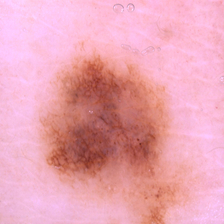

In [31]:
img1

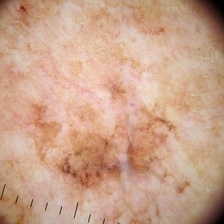

In [32]:
img2

In [33]:
model_inp1 = torch.unsqueeze(compulsory_transforms(image=np.array(img1))["image"], dim=0)
print(model_inp1.shape)
model_inp2 = torch.unsqueeze(compulsory_transforms(image=np.array(img2))["image"], dim=0)
print(model_inp2.shape)


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [34]:
stacked_imgs = torch.vstack([model_inp1, model_inp2])
print(stacked_imgs.shape)

torch.Size([2, 3, 224, 224])


In [35]:
# print(model_inp.shape)
print(loaded_model(stacked_imgs, probab=True))

tensor([[0.9833, 0.0167],
        [0.0068, 0.9932]])


In [36]:
# @title Model Summary
from torchinfo import summary

In [37]:
summary(loaded_model, input_size=(1, 3, 224, 224), device="cpu")

Layer (type:depth-idx)                                  Output Shape              Param #
classifictionModel                                      [1, 2]                    --
├─MobileNetV2: 1-1                                      [1, 2]                    --
│    └─Sequential: 2-1                                  [1, 1280, 7, 7]           --
│    │    └─Conv2dNormActivation: 3-1                   [1, 32, 112, 112]         (928)
│    │    └─InvertedResidual: 3-2                       [1, 16, 112, 112]         (896)
│    │    └─InvertedResidual: 3-3                       [1, 24, 56, 56]           (5,136)
│    │    └─InvertedResidual: 3-4                       [1, 24, 56, 56]           (8,832)
│    │    └─InvertedResidual: 3-5                       [1, 32, 28, 28]           (10,000)
│    │    └─InvertedResidual: 3-6                       [1, 32, 28, 28]           (14,848)
│    │    └─InvertedResidual: 3-7                       [1, 32, 28, 28]           (14,848)
│    │    └─InvertedResidu

## Grad CAM

- [Repo](https://github.com/jacobgil/pytorch-grad-cam)

In [38]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

torch.Size([1, 3, 224, 224]) torch.float32
Probab - tensor([[0.0424, 0.9576]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


array([[[110,  92, 158],
        [111,  92, 161],
        [113,  94, 162],
        ...,
        [ 88, 114, 184],
        [ 89, 114, 183],
        [ 90, 115, 185]],

       [[111,  93, 159],
        [112,  94, 162],
        [114,  96, 165],
        ...,
        [ 88, 111, 181],
        [ 87, 111, 177],
        [ 88, 112, 178]],

       [[112,  94, 160],
        [114,  96, 164],
        [112,  96, 164],
        ...,
        [ 85, 107, 176],
        [ 83, 106, 172],
        [ 85, 107, 172]],

       ...,

       [[107,  88, 153],
        [107,  88, 155],
        [107,  87, 154],
        ...,
        [100,  85, 156],
        [100,  85, 155],
        [100,  84, 155]],

       [[108,  88, 157],
        [107,  88, 154],
        [105,  88, 152],
        ...,
        [ 99,  84, 154],
        [100,  85, 155],
        [100,  85, 155]],

       [[108,  88, 157],
        [105,  87, 152],
        [107,  88, 152],
        ...,
        [ 99,  84, 154],
        [ 99,  84, 155],
        [ 99,  83, 154]]], dtype=uint8)
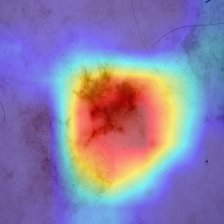

In [40]:
# @title trained loaded_model

# Construct the CAM object once, and then re-use it on many images.
loaded_model_cam = classifictionModel.load_from_checkpoint(trained_model_path)
loaded_model_cam.eval()
# loaded_model_cam.freeze() # DONT FREEZE WHILE USING GRAD CAM


target_layers = [loaded_model_cam.model.features[18][0]]

# load image
image = Image.open("/content/final_dataset/test/malignant/1003.jpg")

image_used = np.array(image) / 255
model_inp1 = torch.unsqueeze(compulsory_transforms(image=np.array(image))["image"], dim=0)
input_tensor = model_inp1

print(input_tensor.shape, input_tensor.dtype)
# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(1),ClassifierOutputTarget(0)]



with GradCAM(model=loaded_model_cam, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  # You can also get the model outputs without having to redo inference
  visualization = show_cam_on_image(
        # torch.permute(torch.squeeze(input_tensor), (1, 2, 0)).numpy(),
        image_used,
        grayscale_cam,
        use_rgb=True
    )
  model_outputs = cam.outputs

print(f"Probab - {loaded_model_cam(input_tensor.to('cuda'), probab=True)}")
visualization